<a href="https://colab.research.google.com/github/lopes-adriano/lia1-2023-1/blob/main/Getting_started_Fast_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. É um pássaro?

Baseado em: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data



Adriano Ferreira Lopes - 201802671

## Instalando e importando dependências.

In [36]:
!pip install duckduckgo_search
!pip install -Uqq fastbook

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Código para a pesquisa de imagens

In [37]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

##Baixando uma imagem de um pássaro e de uma floresta

Searching for 'bird photos'


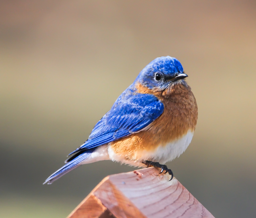

In [38]:
download_url(search_images('bird photos', max_images=1)[0], 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)


Searching for 'forest photos'


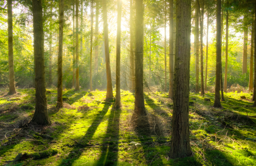

In [39]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## Baixando nossos dados

In [40]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    download_images(dest, urls=search_images(f'{o} sun photo'))
    download_images(dest, urls=search_images(f'{o} shade photo'))

    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


####Removendo imagens que não foram baixadas corretamente

In [41]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Treinando o modelo

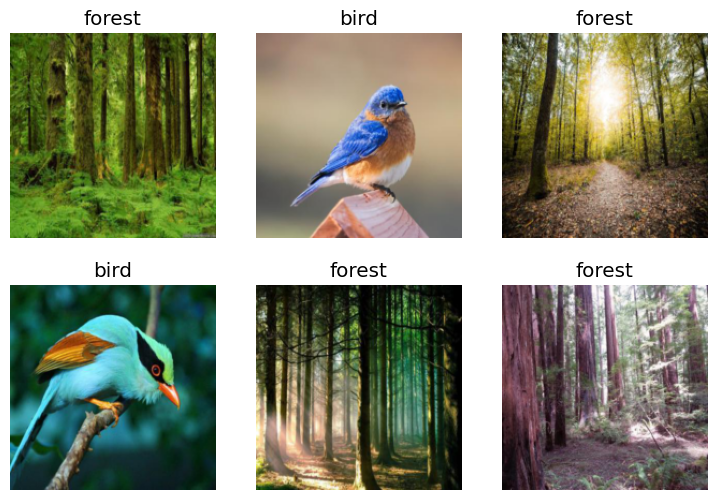

In [42]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [43]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.595980,0.080391,0.020000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.046106,0.001439,0.000000,00:02
1,0.023347,0.001245,0.000000,00:02
2,0.014299,0.000770,0.000000,00:02


## Testando modelo

In [44]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [45]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000


#2. Segmentation

##Obtendo dados e treinando o modelo

In [55]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
     path, bs=8, fnames = get_image_files(path/"images"),
     label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
     codes = np.loadtxt(path/'codes.txt', dtype=str)
)
learn = unet_learner (dls, resnet34)
learn.fine_tune(10)


epoch,train_loss,valid_loss,time
0,3.156287,2.365940,00:01


epoch,train_loss,valid_loss,time
0,2.148051,1.828472,00:01
1,1.840888,1.431638,00:02
2,1.604169,1.168044,00:02
3,1.439250,1.040957,00:02
4,1.298215,0.848590,00:01
5,1.154400,0.752485,00:01
6,1.031863,0.742981,00:01
7,0.933493,0.683750,00:01
8,0.852394,0.679683,00:01
9,0.786791,0.674851,00:01


##Testando o modelo

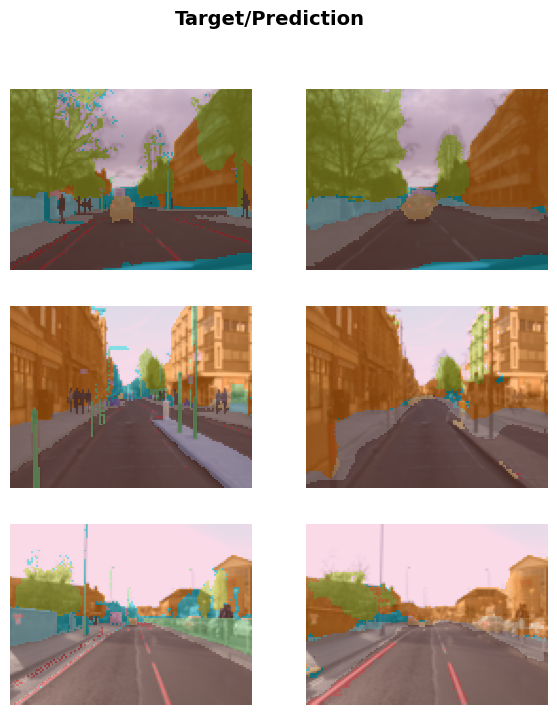

In [56]:
learn.show_results(max_n=3, figsize=(7,8))

#3. Tabular Analysis - income prediction

## Obtendo dados e treinando o modelo

In [60]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names='salary',
      cat_names = ['workclass', 'education', 'marital-status', 'occupation', 
                   'relationship', 'race',],
      cont_names = ['education-num', 'age', 'fnlwgt',],
      procs = [Categorify, FillMissing, Normalize])

dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,education-num,age,fnlwgt,salary
0,Private,Assoc-voc,Never-married,Adm-clerical,Not-in-family,White,False,11.0,23.000000,167868.000286,<50k
1,Self-emp-not-inc,Some-college,Married-civ-spouse,Craft-repair,Husband,White,False,10.0,43.000000,193458.999851,<50k
2,Private,Bachelors,Never-married,Exec-managerial,Own-child,White,False,13.0,24.000000,92608.999190,<50k
3,?,HS-grad,Widowed,?,Not-in-family,White,False,9.0,64.000000,211360.000684,<50k
4,Private,Some-college,Divorced,Sales,Not-in-family,White,False,10.0,28.000000,227103.998870,<50k
5,?,Some-college,Married-civ-spouse,?,Husband,White,False,10.0,57.999999,169982.000350,>=50k
6,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,False,9.0,28.000000,184078.000143,<50k
7,Self-emp-inc,Bachelors,Married-civ-spouse,Sales,Husband,White,False,13.0,41.000000,253059.998868,>=50k
8,Private,HS-grad,Never-married,Craft-repair,Not-in-family,White,False,9.0,43.000000,247879.998794,<50k
9,Private,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,False,16.0,45.000000,214068.000608,>=50k


In [65]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.384873,0.350668,0.833538,00:06
1,0.360636,0.345771,0.840756,00:04


#4. Collaborative filtering - recommendation system

## Obtendo dados e treinando o modelo

In [67]:
from fastai.collab import *

path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

dls.show_batch()

,userId,movieId,rating
0,243,1923,3.0
1,423,1193,5.0
2,212,357,2.5
3,607,4306,4.5
4,212,3793,4.0
5,358,296,5.0
6,355,2628,4.0
7,220,1089,4.0
8,243,4973,5.0
9,561,3114,3.0


In [72]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.517106,1.418218,00:00


epoch,train_loss,valid_loss,time
0,1.371756,1.356619,00:00
1,1.263133,1.175160,00:00
2,1.032136,0.871618,00:00
3,0.795611,0.726621,00:00
4,0.689376,0.687632,00:00
5,0.657871,0.673662,00:00
6,0.616239,0.669188,00:00
7,0.611311,0.665994,00:00
8,0.604135,0.665276,00:00
9,0.602467,0.665047,00:00


## Testando o modelo

In [73]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,95.0,66.0,5.0,3.968466
1,93.0,62.0,4.0,4.210147
2,19.0,18.0,4.0,4.440257
3,91.0,21.0,3.0,3.273653
4,100.0,33.0,5.0,3.132315
5,98.0,60.0,4.0,4.803144
6,55.0,78.0,2.5,3.176064
7,41.0,84.0,3.0,3.907836
8,4.0,42.0,4.5,3.525994
